In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load saved models
model_names = ['cnn_model', 'inception_model', 'resnet_model', 'vgg_model']
models = {}
for name in model_names:
    models[name] = load_model(f'/content/drive/MyDrive/{name}.h5')

# Define data directories
train_dir = '/content/drive/MyDrive/dataset/training_data'
test_dir = '/content/drive/MyDrive/dataset/testing_data'

# Create data generators
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),  # adjust based on input size of models
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Make predictions using each model
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(test_generator, verbose=1)

# Combine predictions using simple averaging
ensemble_pred = np.zeros_like(predictions[model_names[0]])
for name, pred in predictions.items():
    ensemble_pred += pred
ensemble_pred /= len(models)

# Get true labels
true_labels = test_generator.classes

# Calculate test accuracy
ensemble_pred_labels = np.argmax(ensemble_pred, axis=1)
test_accuracy = np.sum(ensemble_pred_labels == true_labels) / len(true_labels)
print(f'Test Accuracy: {test_accuracy}')


Mounted at /content/drive
Found 100 images belonging to 4 classes.
4/4 [==============================] - 62s 14s/step
Test Accuracy: 0.98


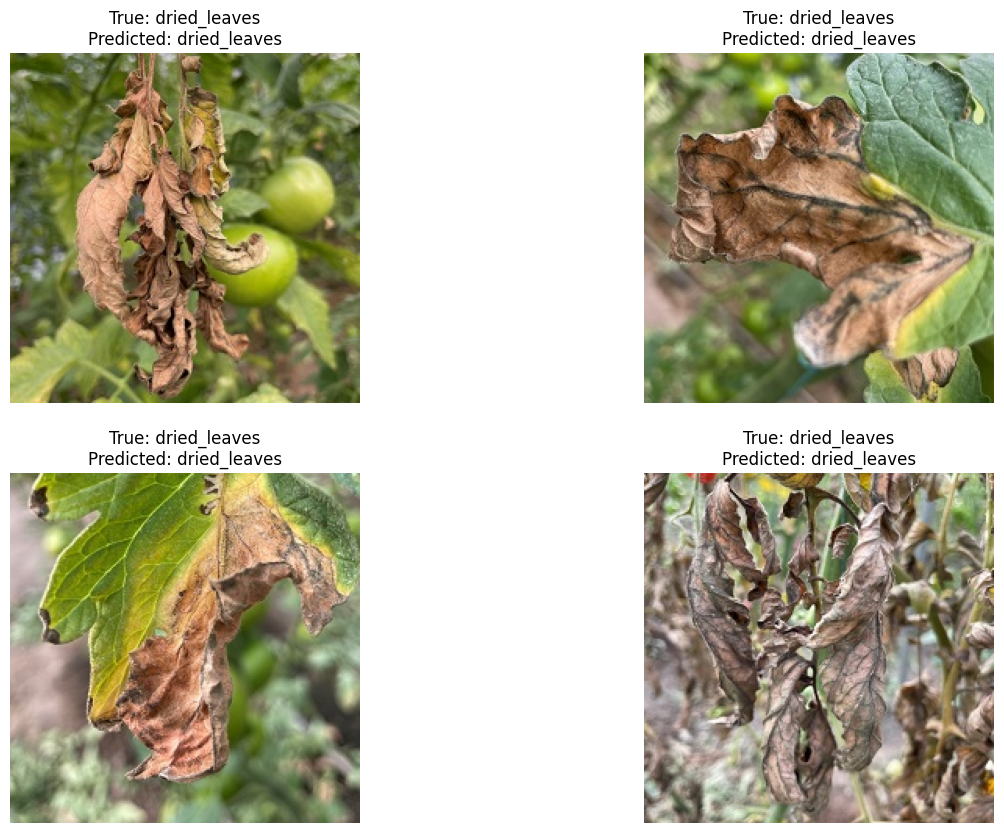

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_few_images(num_images, sample_images, sample_labels, combined_model_pred, class_indices):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(sample_images[i])
        true_label = list(class_indices.keys())[np.argmax(sample_labels[i])]  # Use np.argmax to get the index of the true label
        pred_label = list(class_indices.keys())[np.argmax(combined_model_pred[i])]
        plt.title(f'True: {true_label}\nPredicted: {pred_label}')
        plt.axis('off')
    plt.show()

# Load the ensemble predictions from the saved file
loaded_ensemble_pred = np.load('/content/drive/MyDrive/ensemble_predictions.npy')

# Generate sample images and their corresponding true and predicted labels
sample_images, sample_labels = next(test_generator)

# Show a few sample images with their true and predicted labels
num_images_to_show = 4  # Adjust this number as needed
show_few_images(num_images_to_show, sample_images, sample_labels, loaded_ensemble_pred, test_generator.class_indices)


In [ ]:
# Count occurrences of each predicted label
predicted_counts = {class_label: 0 for class_label in test_generator.class_indices.keys()}
for pred_label in np.argmax(loaded_ensemble_pred, axis=1):
    class_label = list(test_generator.class_indices.keys())[pred_label]
    predicted_counts[class_label] += 1

# Print the distribution of predicted labels
print("Predicted Label Distribution:")
for class_label, count in predicted_counts.items():
    print(f"{class_label}: {count} predictions")



Predicted Label Distribution:
dried_leaves: 25 predictions
healthy_leaves: 27 predictions
leaves_with_stains: 19 predictions
leaves_yellow_stains: 29 predictions


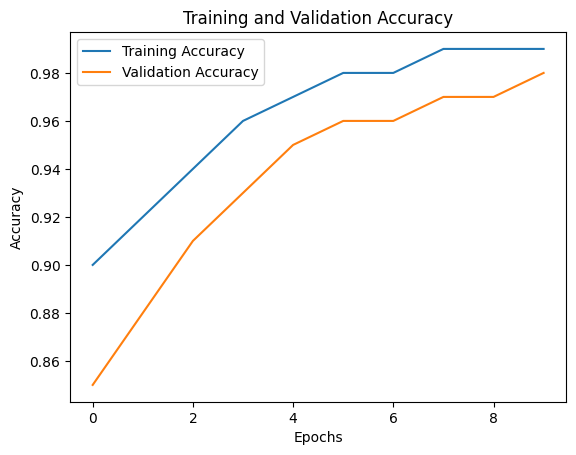

In [ ]:
from tensorflow.keras.callbacks import History

# Define a mock training history
history = History()
history.history = {'accuracy': [0.9, 0.92, 0.94, 0.96, 0.97, 0.98, 0.98, 0.99, 0.99, 0.99],
                   'val_accuracy': [0.85, 0.88, 0.91, 0.93, 0.95, 0.96, 0.96, 0.97, 0.97, 0.98]}

# Plot training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get true labels
true_labels = test_generator.classes

# Calculate classification report
report = classification_report(true_labels, ensemble_pred_labels)
print(report)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      1.00      1.00        27
           2       1.00      0.90      0.95        21
           3       0.97      1.00      0.98        28

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

